In [2]:
library(dplyr, quietly = TRUE)
library(xts, quietly = TRUE)
library(forecast, quietly = TRUE)
library(lubridate)

# Non-Farm Jobs Data

Goals: 
1. Explore the jobs data. What can you find out about it? 
2. Use Necessary method to forecast the time series. 

In [3]:
# define a function that will  calculate the percent change of a time series
pct_change = function(x){
    today = x # P_t 
    yesterday = stats::lag(x, 1) # P_{t-1}
    (today - yesterday) / yesterday
}

df = read.csv('data/employment.csv')

Industry standard: to look at the change in nonfarms

In [188]:
nonfarms = xts(df$total_nonfarm_employment, order.by = ymd(df$Date))
# filter the year 2021-01-01 to 2021-03-31
nonfarms = nonfarms[index(nonfarms)>'2021-10-01']

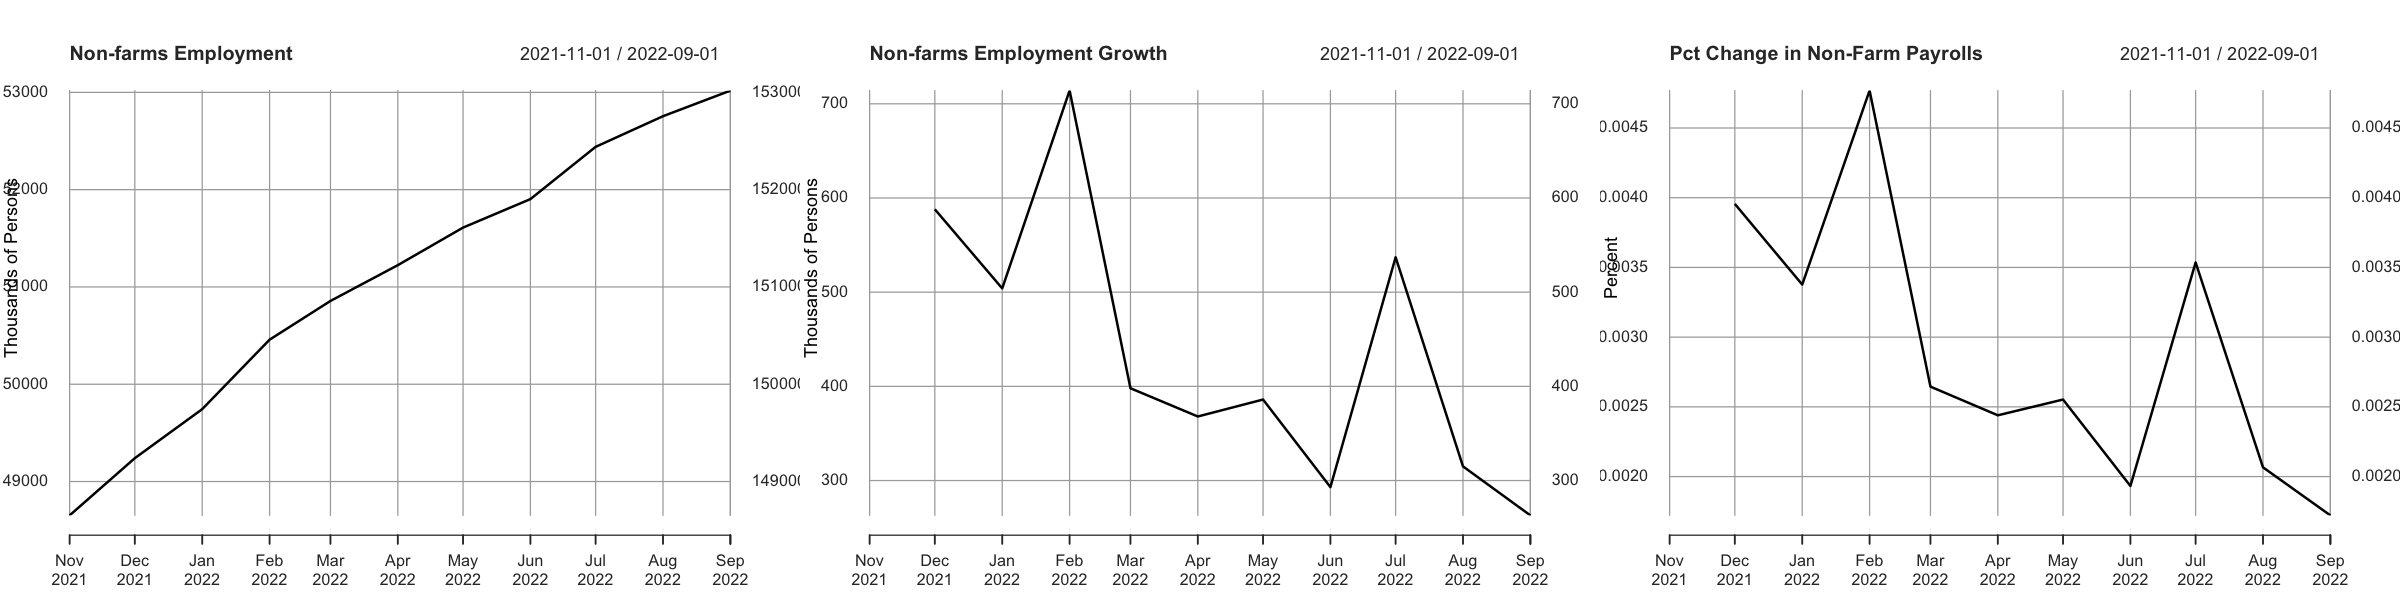

In [189]:
names(nonfarms) = 'Non-farms'
par(mfcol = c(1,3))
options(repr.plot.width = 20, repr.plot.height = 5)
plot(nonfarms, main = 'Non-farms Employment', ylab = 'Thousands of Persons')
plot(diff(nonfarms), main = 'Non-farms Employment Growth', ylab = 'Thousands of Persons')
plot(pct_change(nonfarms), main = 'Pct Change in Non-Farm Payrolls', ylab = 'Percent')

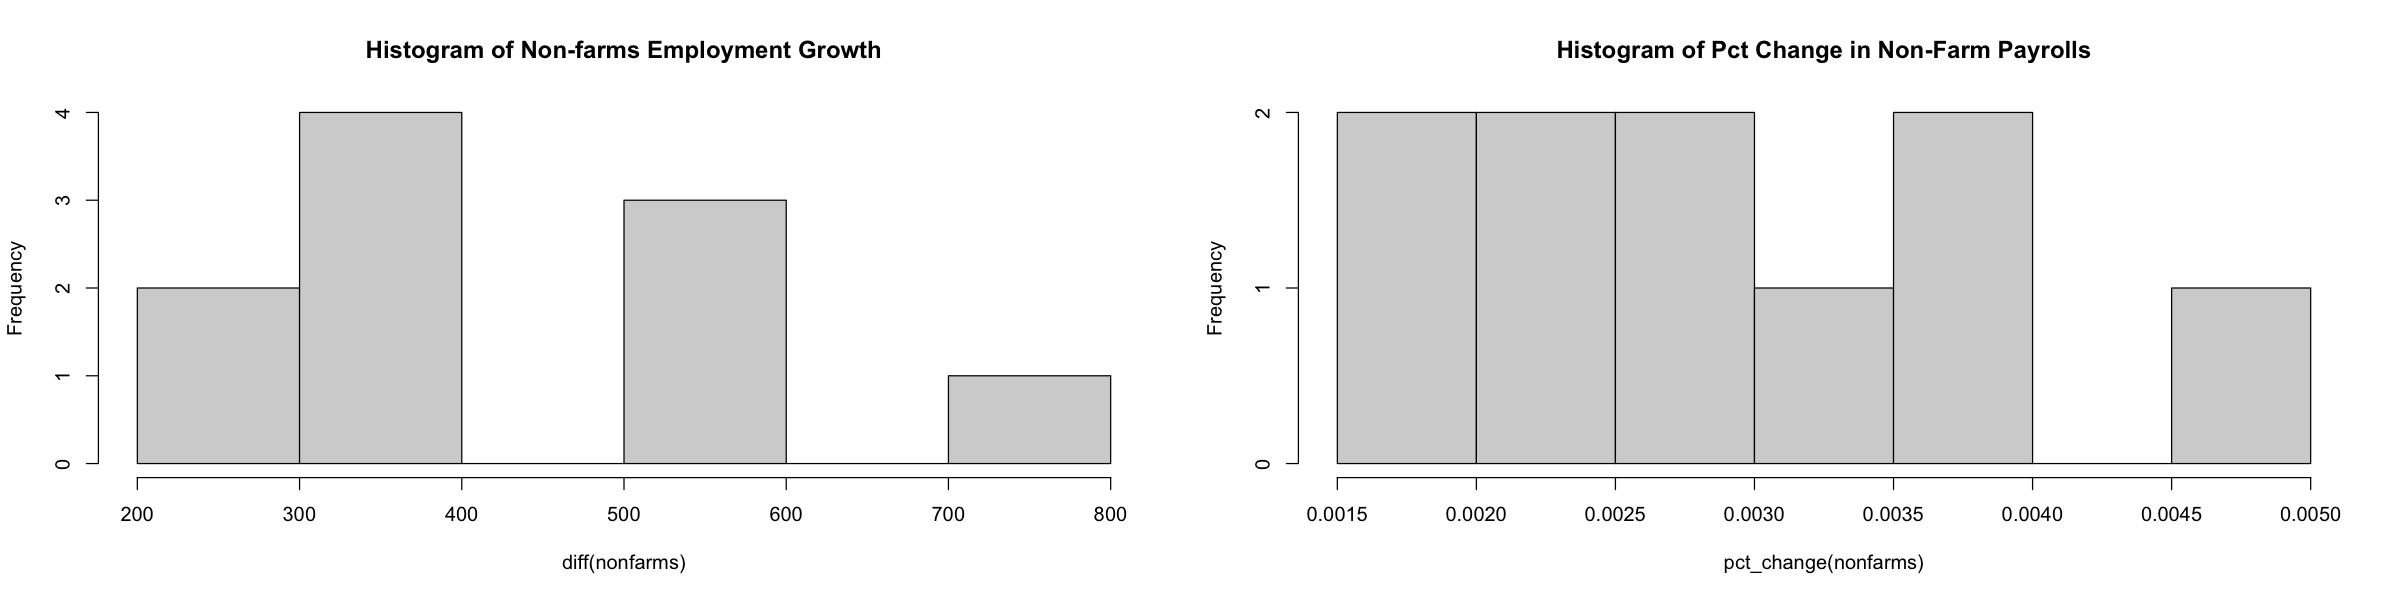

In [190]:
par(mfcol = c(1,2))
hist(diff(nonfarms), main = 'Histogram of Non-farms Employment Growth', ylab = 'Frequency')
hist(pct_change(nonfarms), main = 'Histogram of Pct Change in Non-Farm Payrolls', ylab = 'Frequency')


- Cant really tell anything about the data, looks like covid in 2020 really messed with it. However its been on a tear ever since. 

In [6]:
# apply splines regression to the time series
np_trend = function(x){
    # if x is a ts object, convert it to an xts object
    require(mgcv)
    n = c(1:nrow(x))
    model = gam(x ~ s(n))
    data.frame(value = x, estimate = fitted(model)) %>% xts(order.by  = index(x))
    }


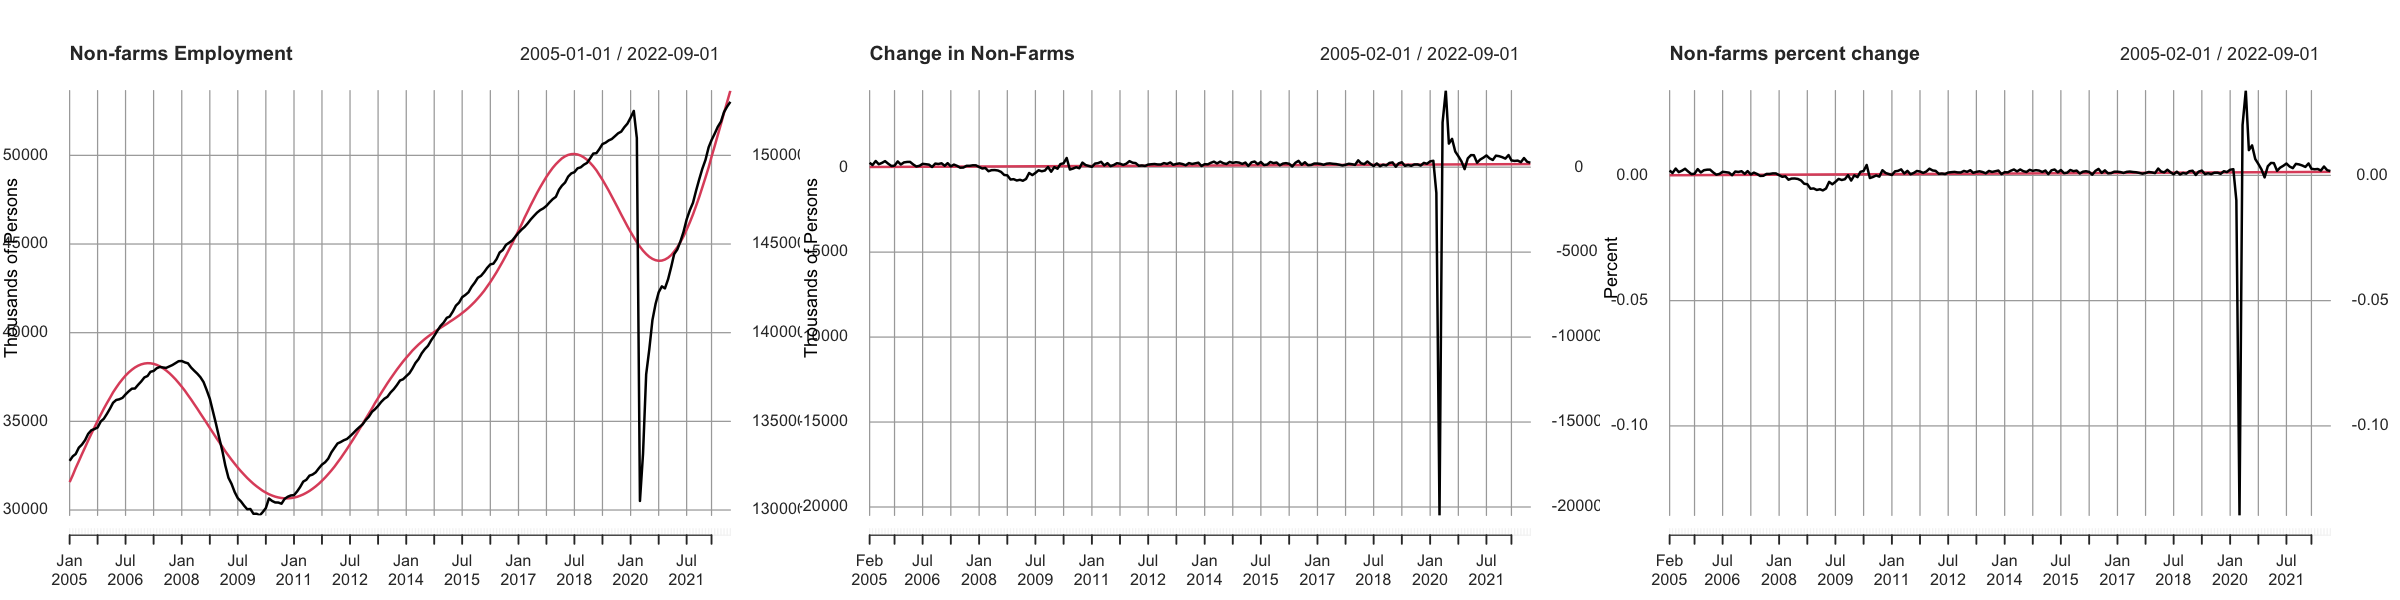

In [18]:
par(mfcol = c(1,3))
og = nonfarms %>% np_trend() 
diff_og = diff(nonfarms) %>% na.omit() %>% np_trend()
pchd = pct_change(nonfarms) %>% na.omit() %>% np_trend()

plot(og, main = 'Non-farms Employment', ylab = 'Thousands of Persons')
plot(diff_og, main = 'Change in Non-Farms', ylab = 'Thousands of Persons')
plot(pchd, main = 'Non-farms percent change', ylab = 'Percent')


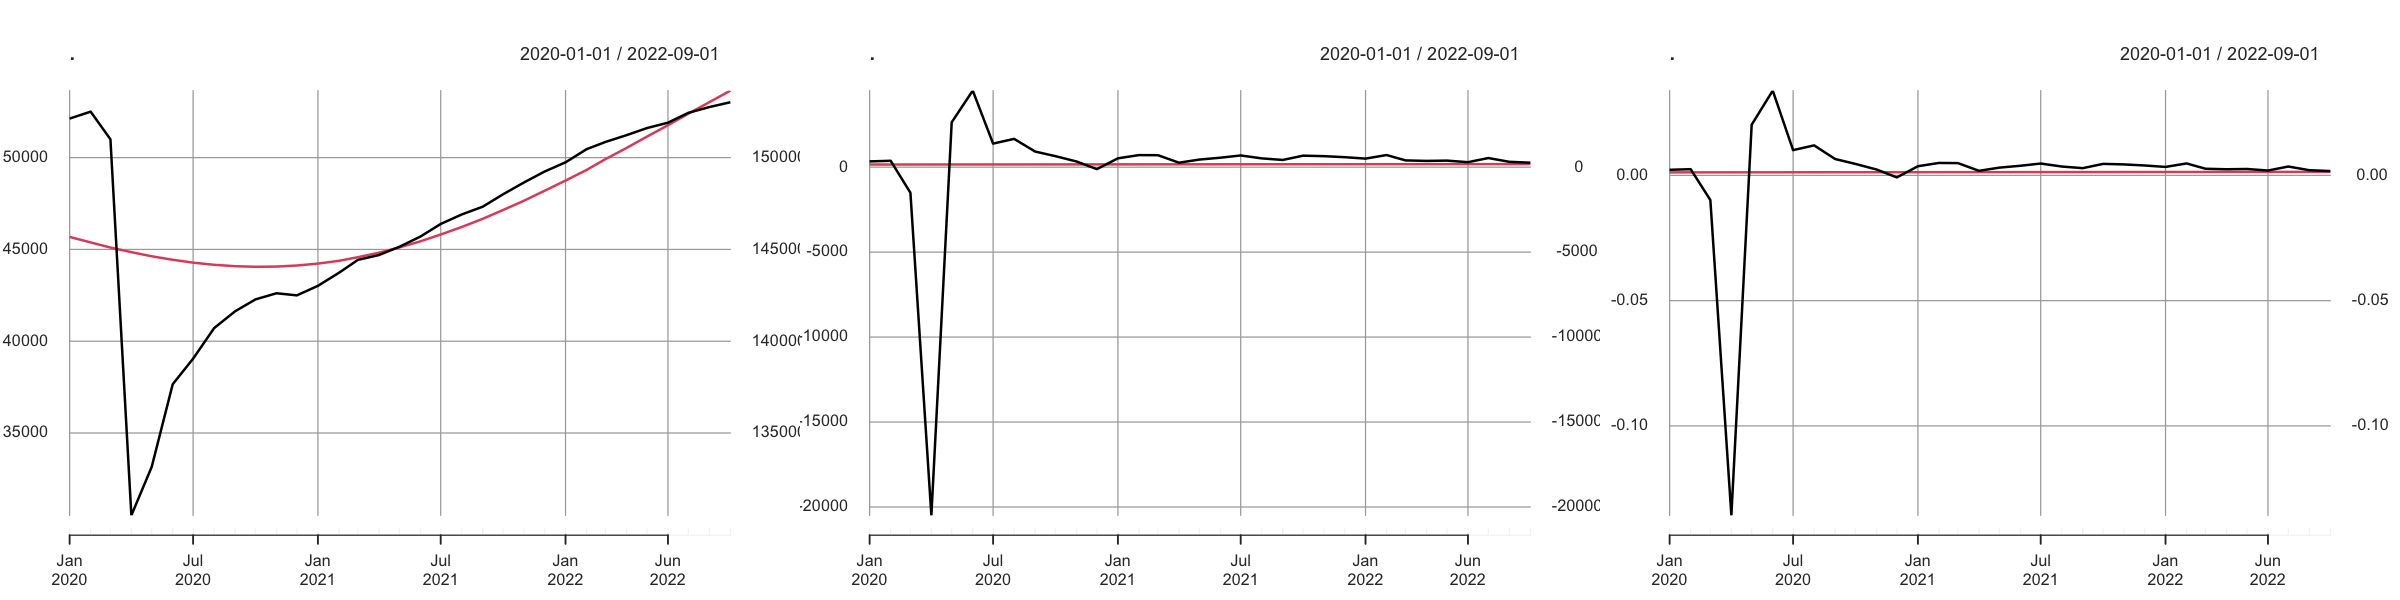

In [19]:
par(mfcol = c(1,3))
window(og, start = '2020-01-01') %>% plot('Non-farms')
window(diff_og, start = '2020-01-01') %>% plot('Change in Non-farms')
window(pchd, start = '2020-01-01') %>% plot('Percent Change in Non-farms')

In [21]:
auto.arima(diff(nonfarms))

Series: diff(nonfarms) 
ARIMA(0,0,0) with zero mean 

sigma^2 = 2230017:  log likelihood = -1850.27
AIC=3702.54   AICc=3702.56   BIC=3705.9

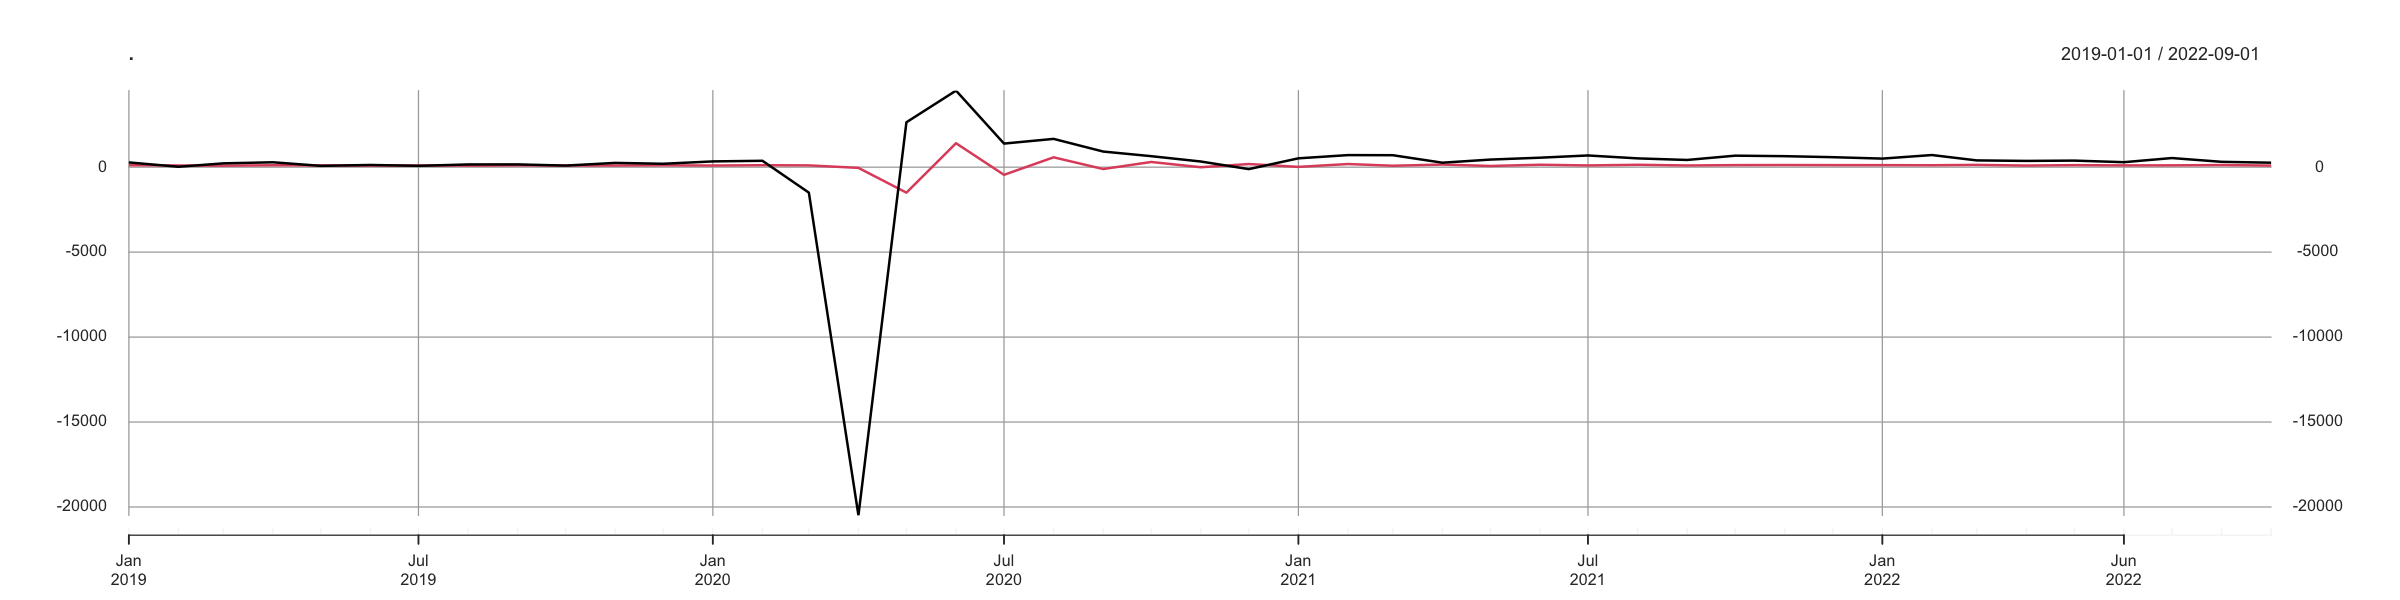

In [26]:
# fit an ARIMA model to the time series
arima_model = function(x, order){
    model = arima(x, order = order)
    data.frame(value = x, estimate = fitted(model)) %>% xts(order.by  = index(x))
}
non_farm_arima = arima_model(diff(nonfarms), c(1,0,1))
window(non_farm_arima, start = '2019-01-01') %>% plot()


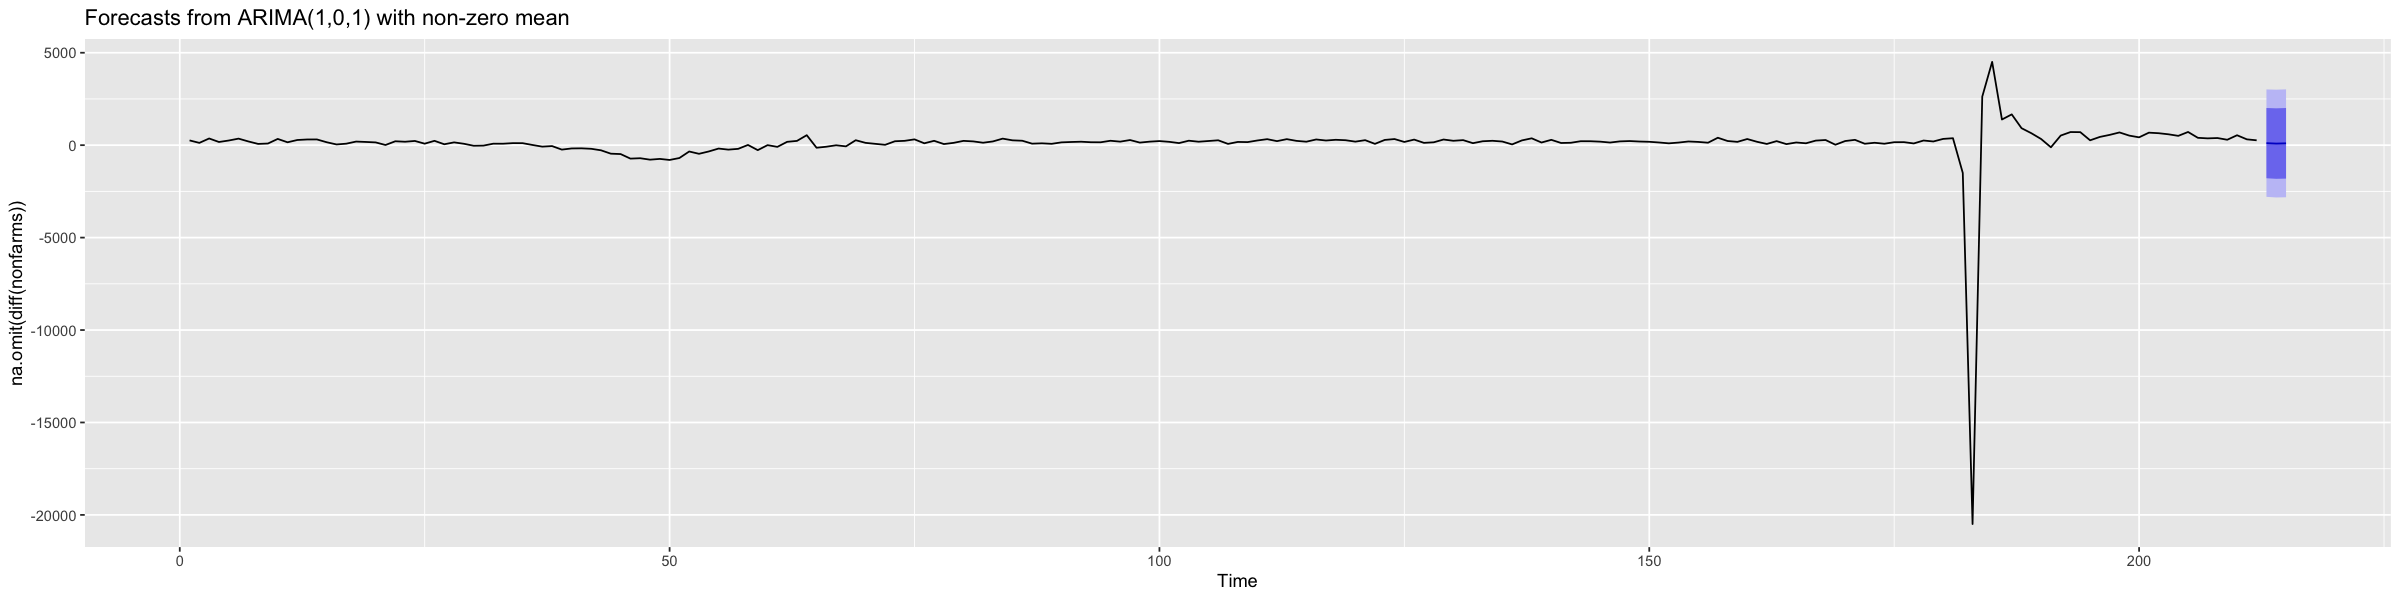

In [69]:
# Use the ARIMA model to forecast the time series
arima(na.omit(diff(nonfarms)), order = c(1,0,1)) %>%  forecast(h = 3) %>% autoplot()


          Oct      Nov      Dec
2022 283.8561 218.9903 248.1842

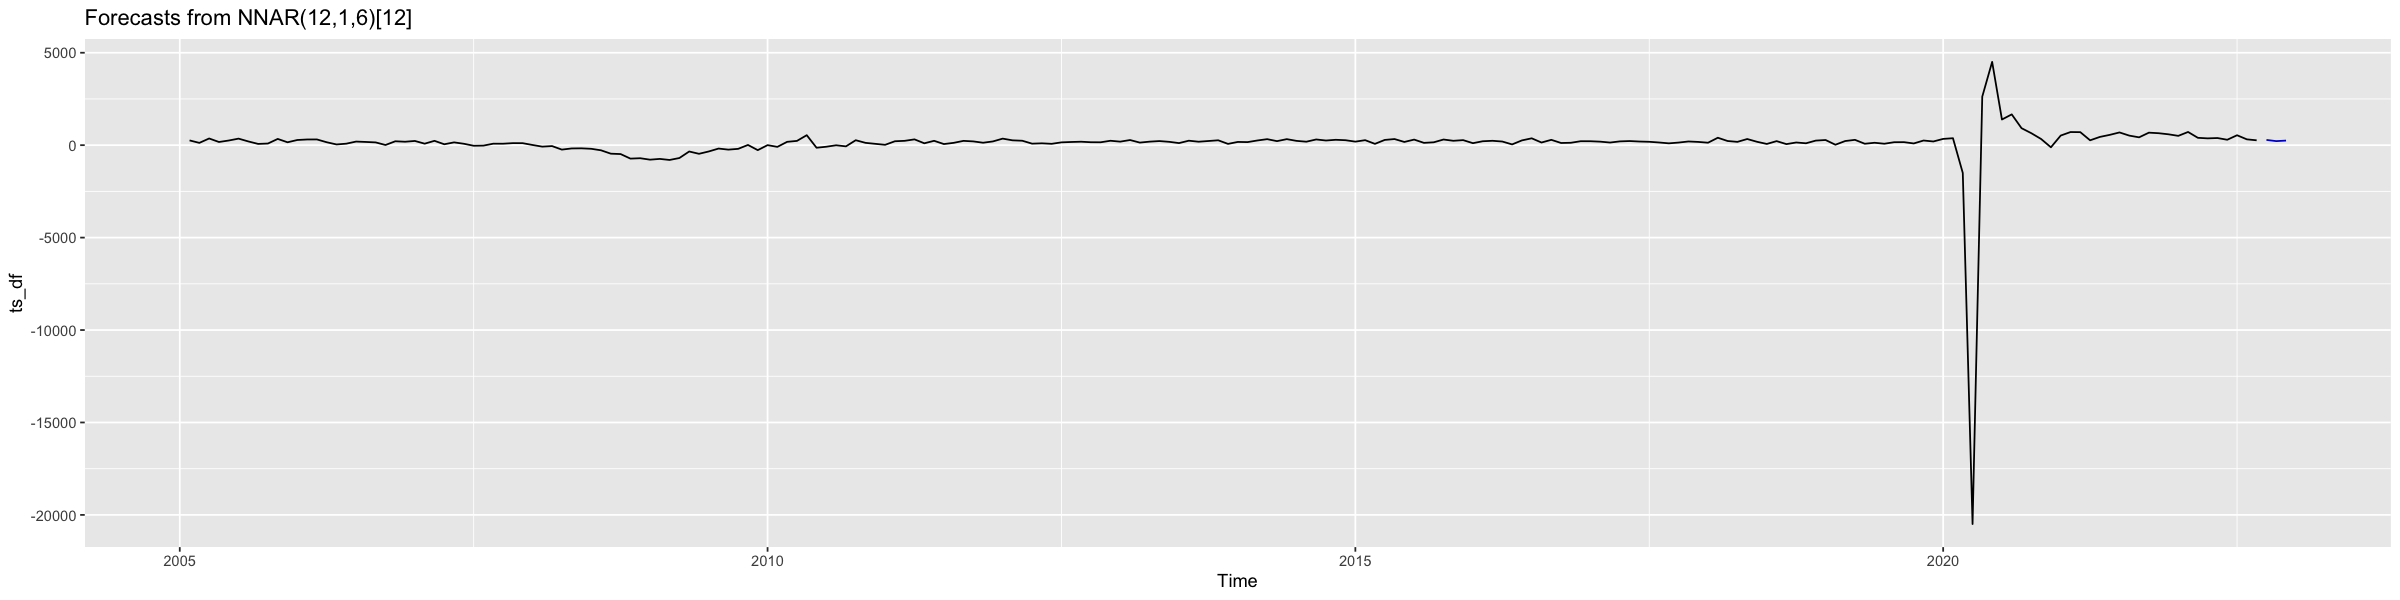

In [135]:
library(tsbox)
set.seed(420)
# Why time series objects are better than xts? 
# Example below. 
ts_df = na.omit(diff(nonfarms))
ts_df = ts_ts(ts_df)
fit = nnetar(ts_df, lambda = 0.1)
fit %>% forecast(h = 3) %>% autoplot()
fit %>% forecast(h = 3)

In [136]:
sim <- ts(matrix(0, nrow=30L, ncol=9L),
  start=end(ts_df)[1L]+1L)



In [137]:
for(i in seq(9))
  sim[,i] <- simulate(fit, nsim=30L)


For a multivariate time series, specify a seriesname for each time series. Defaulting to column names.



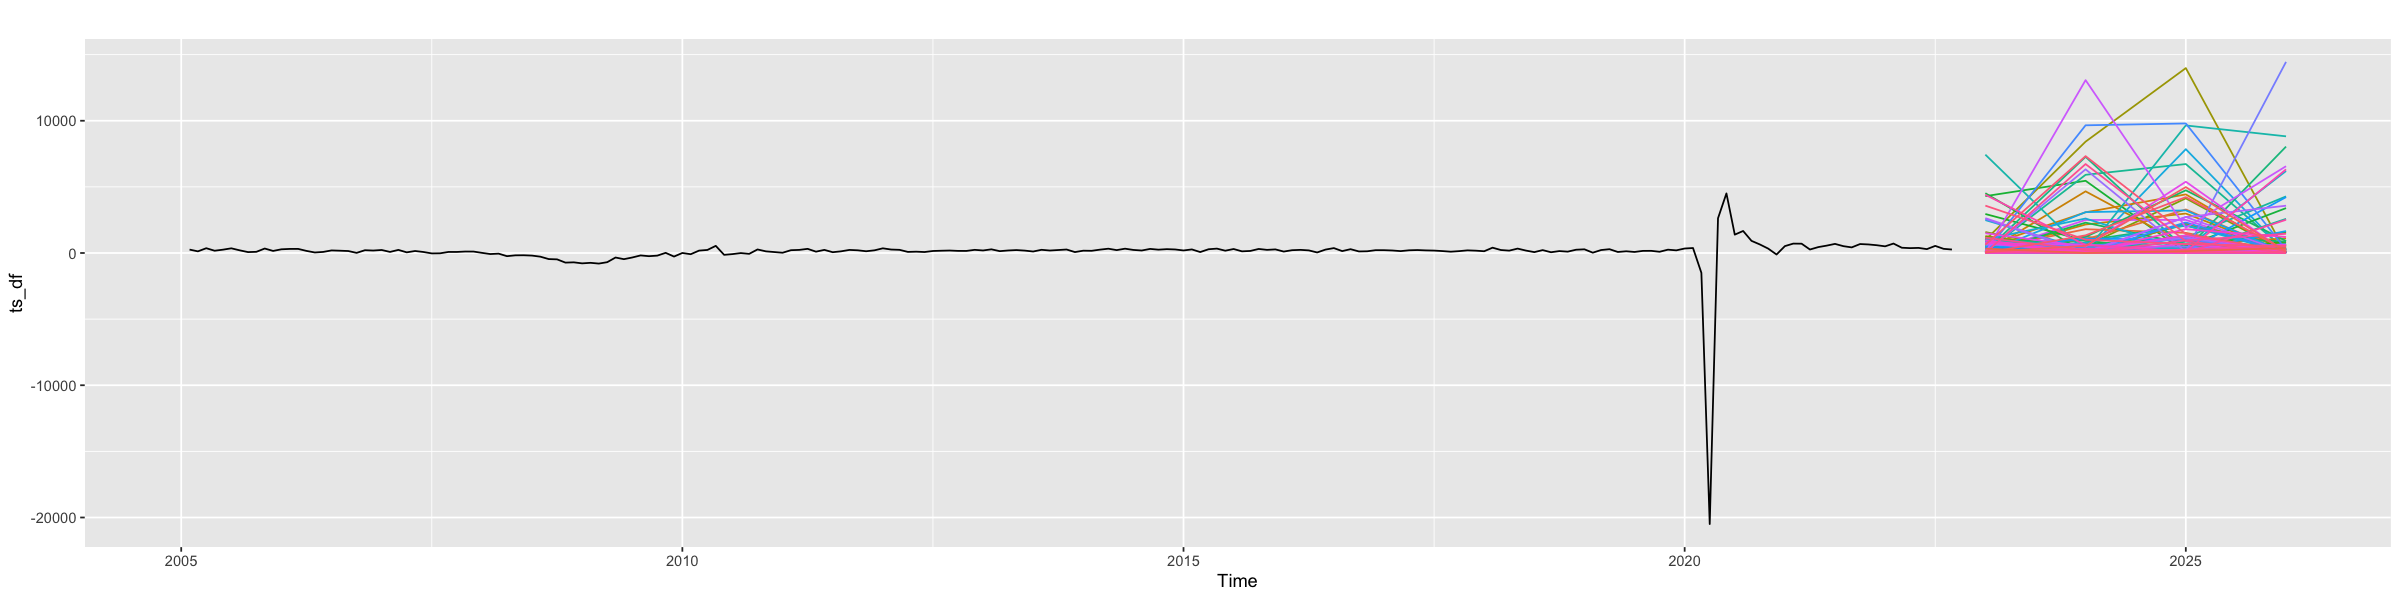

In [144]:
# conver sim to xts
sim <- ts(matrix(0, nrow=4, ncol=100L),
  start=end(ts_df)[1L]+1L)
for(i in seq(100))
  sim[,i] <- simulate(fit, nsim=4)
autoplot(ts_df) + autolayer(sim, show.legend = FALSE)

         Point Forecast    Lo 80    Hi 80    Lo 95     Hi 95
Oct 2022       283.8561 17.59488 2721.668 2.844375  7748.369
Nov 2022       218.9903 12.42540 2619.187 1.404073  6333.726
Dec 2022       248.1842 11.15622 3155.912 1.078175 10545.971

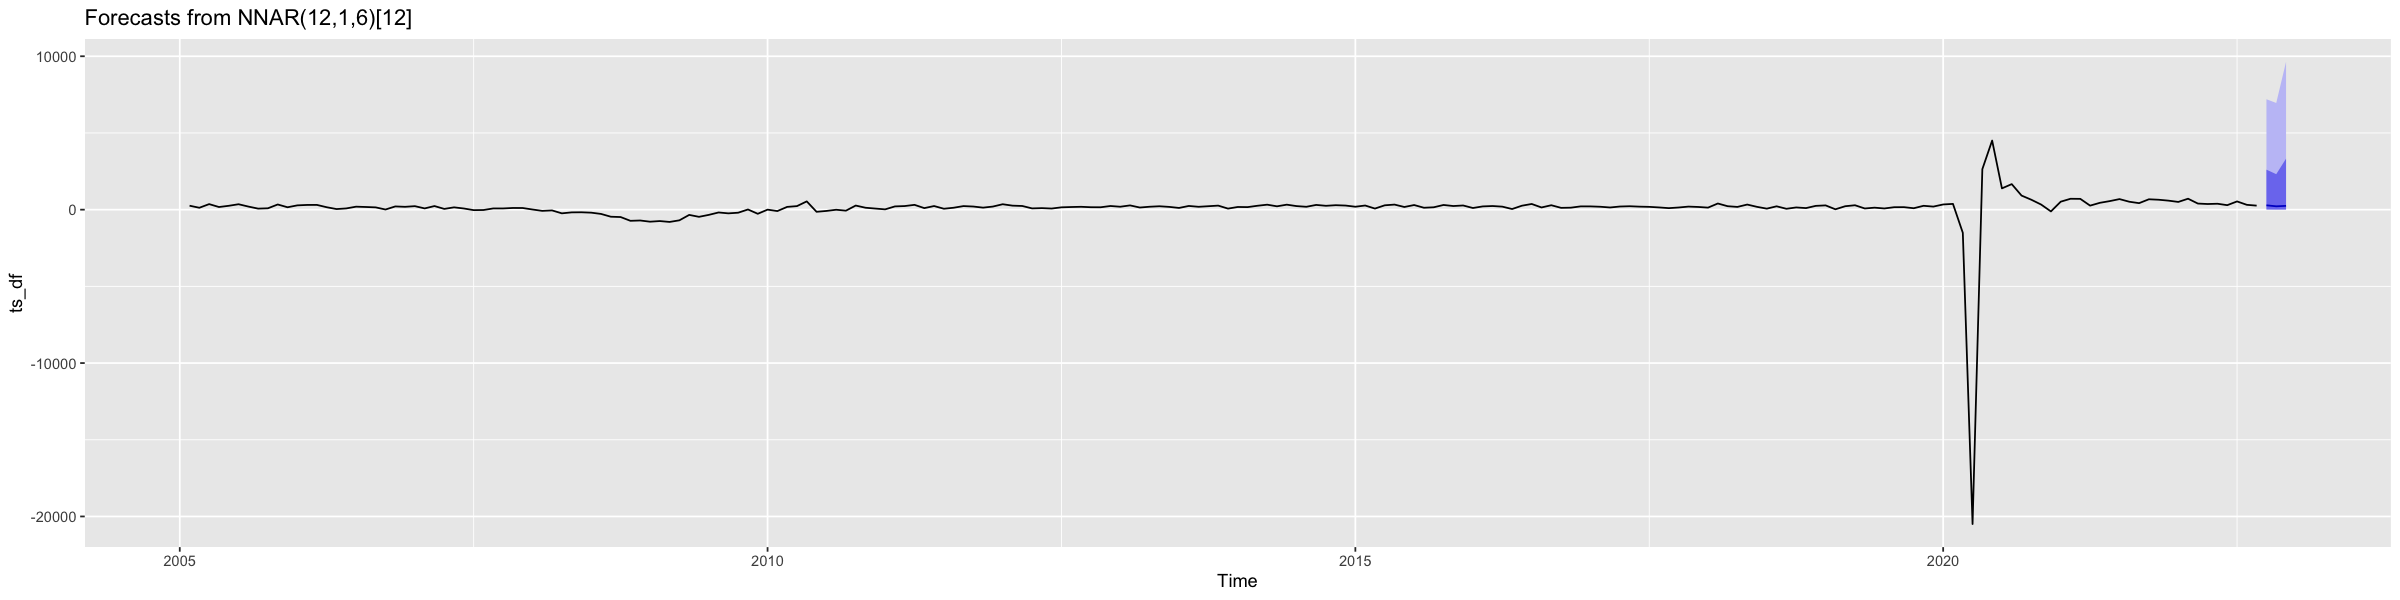

In [147]:
forecast(fit, h = 3, PI = TRUE, npaths = 10000) %>% autoplot()
forecast(fit, h = 3, PI = TRUE)

In [148]:
accuracy(fit)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,9.599427,550.8122,142.834,-4.841654,51.88141,0.2916319,0.07364146


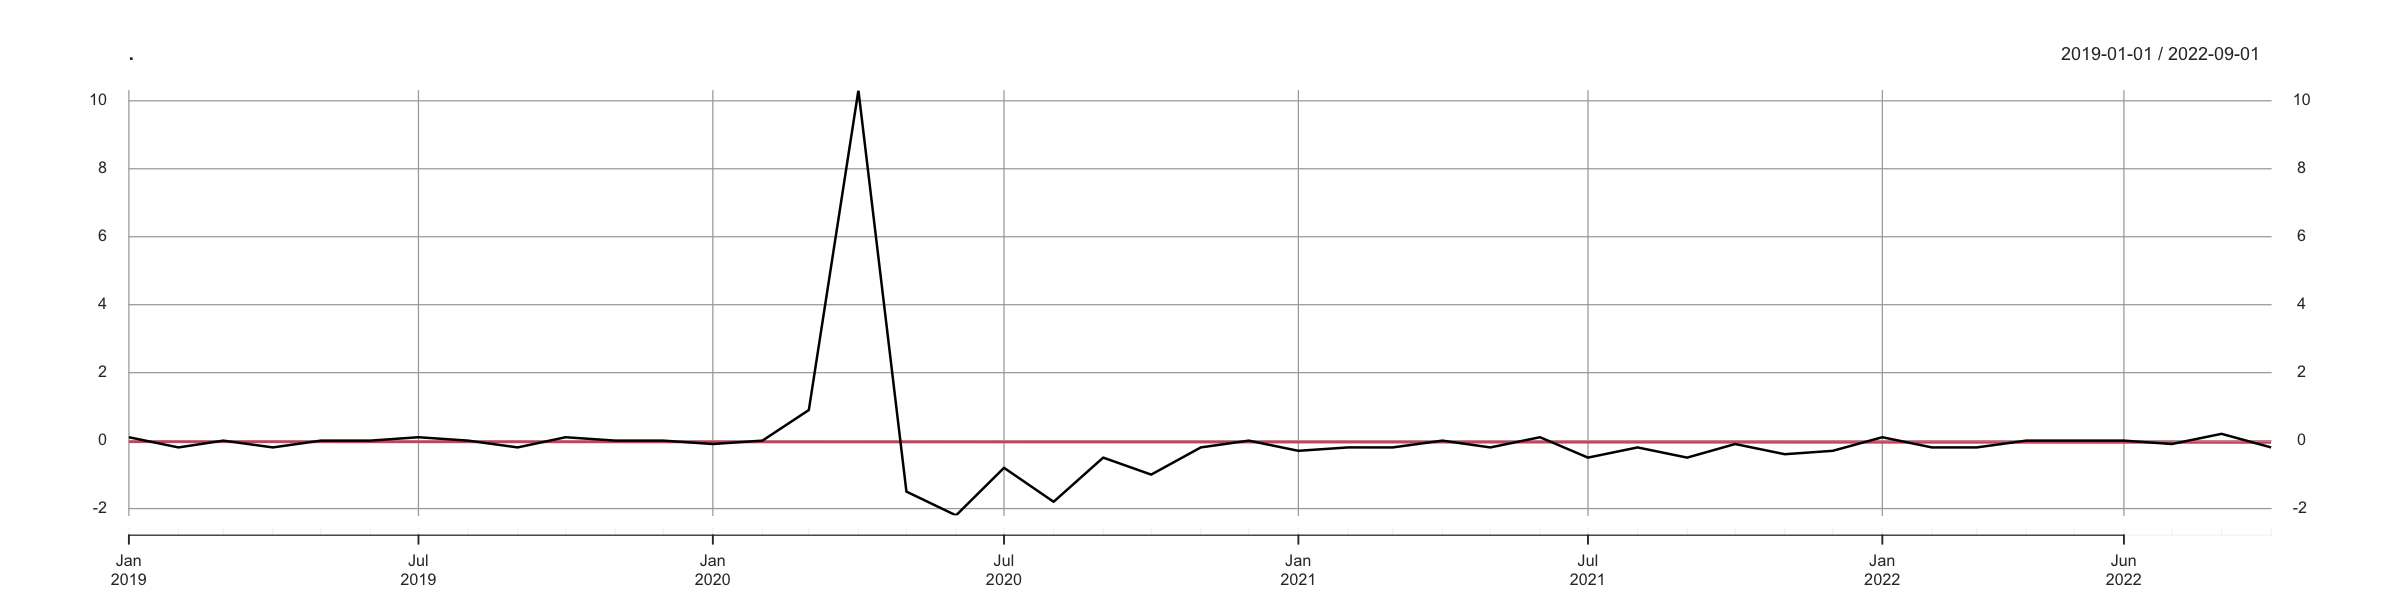

In [67]:
ue = df$unemployment_rate %>% xts(order.by = ymd(df$Date)) %>% diff() %>% na.omit() 
names(ue) = 'Unemployment Rate'
ue %>% np_trend() %>%
    window(start = '2019-01-01') %>% plot()

    Point Forecast      Lo 80     Hi 80     Lo 95    Hi 95
213              0 -0.9858726 0.9858726 -1.507762 1.507762
214              0 -0.9858726 0.9858726 -1.507762 1.507762
215              0 -0.9858726 0.9858726 -1.507762 1.507762

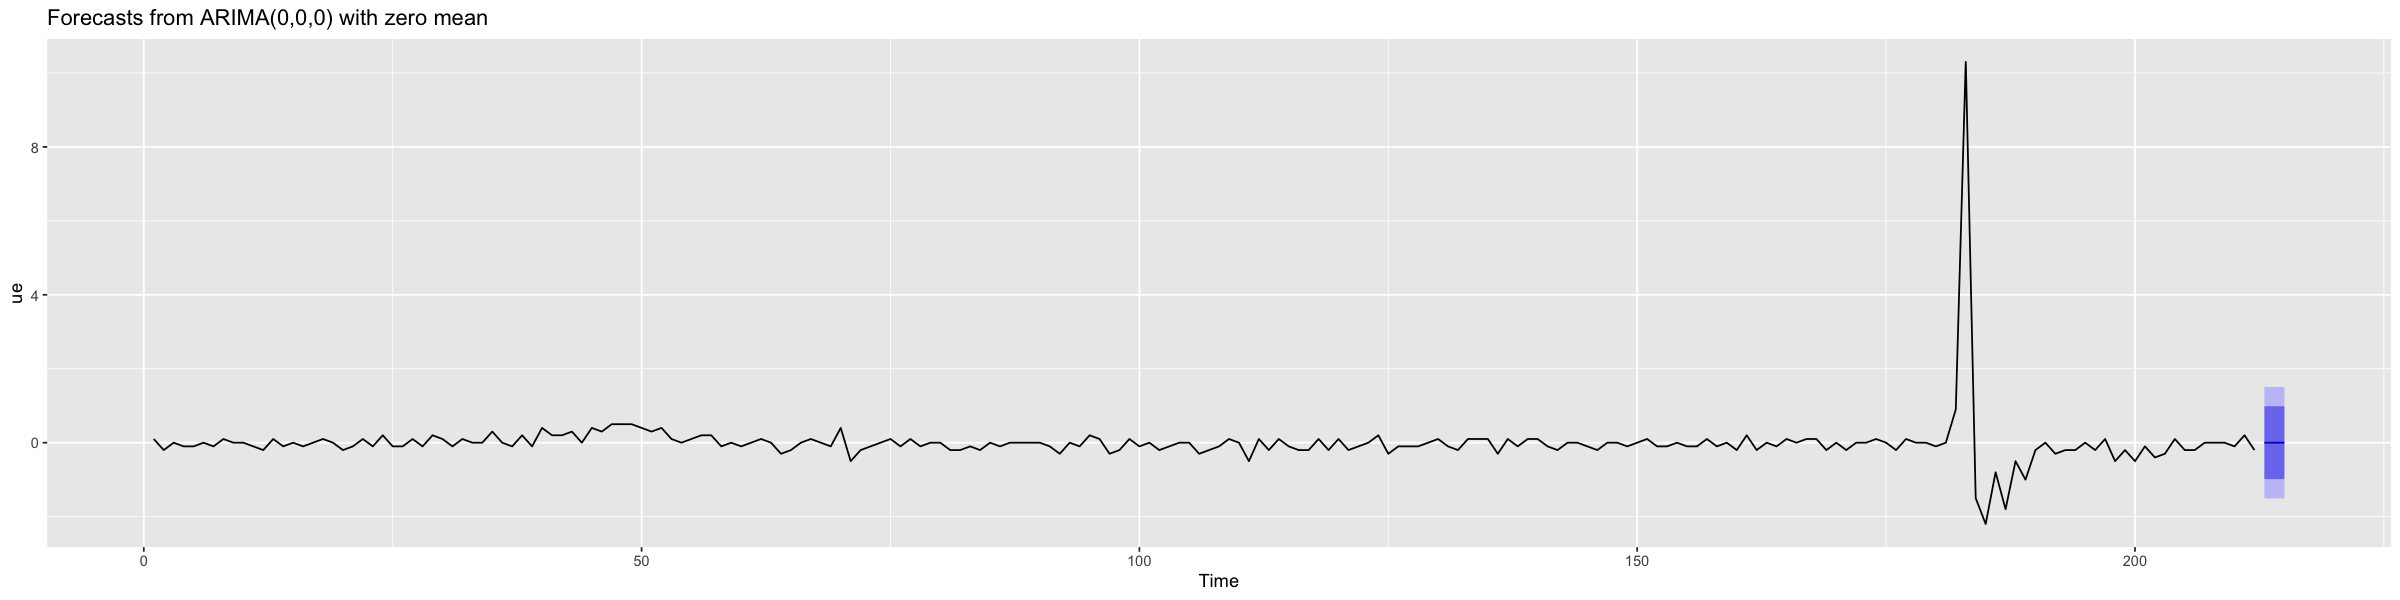

In [68]:
auto.arima(ue) %>% forecast(h = 3) %>% autoplot()
auto.arima(ue) %>% forecast(h = 3)